# Recruit Restaurant Forecasting Using ARIMA Model

** This notebook is the followup for the EDA notebook. Here i will be using the knowledge gained from the EDA of the files given in the competetion. ** 

* The main goal of this notebook is to forecast the number of visitors for all the restaurants given in the sample_submission.csv file.

* The train set contains time series data for air restaurants from 01-01-2016 to 22-04-2017

* The test set contains the restaurants for which the forecast has to be performed from 23-04-2017 to 31-05-2017

* The forecasting length is for 39 days

* Golden Week in 2016 - 29th April to 5th May

* Golden Week in 2017 - 29th April to 5th May **same as 2016**

* This model is the benchmark model for my further models


# 1) Importing the necessary modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import math
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
import statsmodels.api as sm
from datetime import datetime
from dateutil.parser import parse

In [4]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import statsmodels.tsa.api as smt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import calendar
from sklearn.metrics import r2_score
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

# 2) Data I/O

In [5]:
air_reserve = pd.read_csv('air_reserve.csv')
hpg_reserve = pd.read_csv('hpg_reserve.csv')
air_store_info = pd.read_csv('air_store_info.csv')
hpg_store_info = pd.read_csv('hpg_store_info.csv')
air_visit_data = pd.read_csv('air_visit_data.csv')
date_info = pd.read_csv('date_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
sample_submission.head(5)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


# 3) Minimal Exploratory Data Analysis

***I am just showing some basic graphs necessary for the naive ARIMA (SARIMAX) model***

In [7]:
df2=air_visit_data
df2['visit_date']=pd.to_datetime(df2['visit_date'])
df2.set_index(['visit_date'],inplace=True)
df2.index.name=None
df3=pd.DataFrame()
df3['visit_total']=df2.groupby(df2.index,squeeze=True,sort=True)['visitors'].sum()
df3['visit_mean']=df2.groupby(df2.index,squeeze=True,sort=True)['visitors'].mean()
df3['reserve_cnt']=df2.groupby(df2.index,squeeze=True,sort=True)['visitors'].count()

In [8]:
df3.head()

,visit_total,visit_mean,reserve_cnt
2016-01-01,1033,21.520833,48
2016-01-02,1764,28.000000,63
2016-01-03,2368,29.234568,81
2016-01-04,3326,21.184713,157
2016-01-05,3927,17.000000,231


In [9]:
#Get the date info with dow and holidays
hol=date_info
hol=date_info.rename(columns={'calendar_date':'visit_date'})
hol['visit_date'] = pd.to_datetime(hol['visit_date'])
hol.set_index(['visit_date'], inplace=True)
hol.index.name=None
hol.day_of_week = hol.day_of_week.apply(list(calendar.day_name).index)

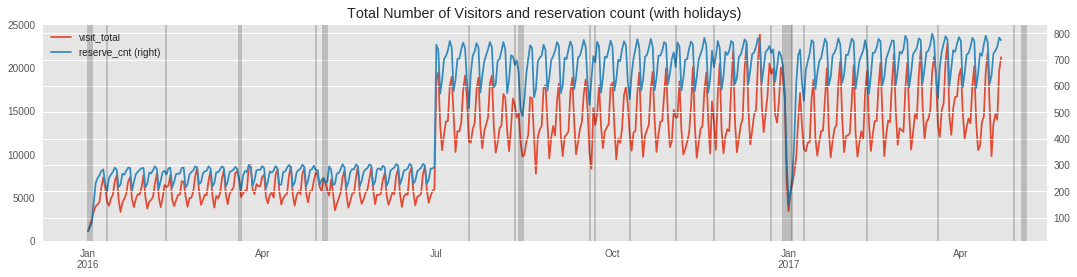

In [10]:
#Plot the cumulative visits
plt.style.use('ggplot')
df3['visit_total'].plot(legend=True);
df3['reserve_cnt'].plot(legend=True, figsize=(18,4), secondary_y=True,
                      title='Total Number of Visitors and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.2);

** Observations: ** From the above graph we can see that there is a sharp jump in the number of visitors in the month of July.

1) This is because of the new restaurants being added into air database. (Inference from EDA Notebook)

2) There is also drop in visits and reservation counts in the beginning of the years, probably due to stores being close around new year's eve.

**Time Series aspects:** 
* The data has sesonal pattern (weekly)
* The trend is not very clear (Incresaing on an overall obs)

**May be looking at mean number of cumulative reservations could help**

Mean of the cumulative visits (sum of all visits divided by number of reservations or, which is the same, the number of "active" restaurants). By exploring this i could gain some information about the time series

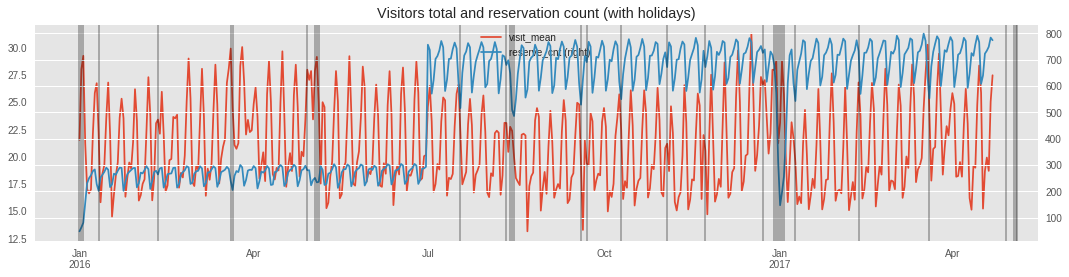

In [11]:
df3['visit_mean'].plot(figsize=(15,4), legend=True, title='Visitors mean (with holidays)')
df3['reserve_cnt'].plot(legend=True, figsize=(18,4), secondary_y=True, title='Visitors total and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

**Observation:** The series does not show the gap in July 2016 anymore, though variance seems to become smaller for some months.

** The time series pattern is bit complex. Decomposition plot will help to decompose into various components plots will help**

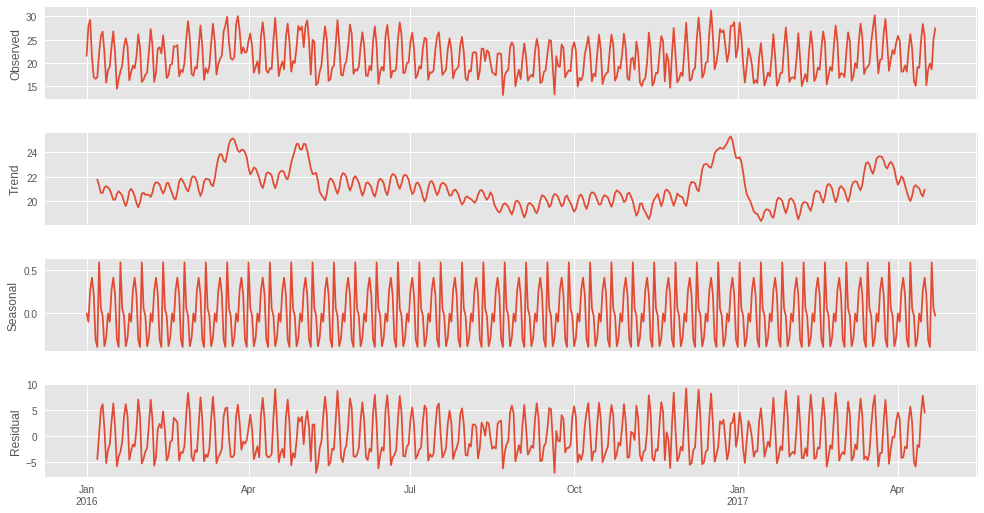

In [12]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df3.visit_mean, freq=12) # Monthly for a year so freq is 12 
fig = plt.figure()
plt.style.use('ggplot')
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

**Observations**: Time Series aspects:

* The trend is increasing till Apr 2016 and rises because of golden week in end of april and decreses afterwards.
* The tred increases again before the 2017 new years eve and then eventually drops off and a slight increase after feb 2017

* The seasonal pattern is pretty clear. Appears weekly (Also Inference from EDA notebook)

**Final Inference**: *The time series has both seasonal and trend components in it. So the SARIMAX model with (p,d,q)(P,D,Q,m) parameters should be used.* 

** Till now total air visits for all the restaurants are plotted. But there are multiple restaurants in the dataset,and the forecast has to be done for each restaurant.**

### *Therefore, we need to look at the individual restaurant as an individual time series data.*


## Taking a restaurant perspective of the problem

In [13]:
air_visit_data.reset_index(inplace=True)

In [14]:
air_visit_data.rename(columns={'index':'visit_date'},inplace=True)
air_visit_data.head()

,visit_date,air_store_id,visitors
0,2016-01-13,air_ba937bf13d40fb24,25
1,2016-01-14,air_ba937bf13d40fb24,32
2,2016-01-15,air_ba937bf13d40fb24,29
3,2016-01-16,air_ba937bf13d40fb24,22
4,2016-01-18,air_ba937bf13d40fb24,6


In [15]:
ts = air_visit_data.groupby(['air_store_id']).get_group('air_ba937bf13d40fb24')[['visit_date', 'visitors']]
#ts.set_index(['visit_date'], inplace=True)
#ts.index.name = None
ts.head()

,visit_date,visitors
0,2016-01-13,25
1,2016-01-14,32
2,2016-01-15,29
3,2016-01-16,22
4,2016-01-18,6


In [16]:
hol.reset_index(inplace=True)
hol.rename(columns={'index':'visit_date'},inplace=True)

In [17]:
hol.visit_date=pd.to_datetime(hol.visit_date)

In [18]:
ts.sort_values(by=['visit_date'],inplace=True)

In [19]:
ts_df=pd.merge(hol,ts,on='visit_date',how='left')
ts_df.head(20)

,visit_date,day_of_week,holiday_flg,visitors
0,2016-01-01,4,1,NaN
1,2016-01-02,5,1,NaN
2,2016-01-03,6,1,NaN
3,2016-01-04,0,0,NaN
4,2016-01-05,1,0,NaN
5,2016-01-06,2,0,NaN
6,2016-01-07,3,0,NaN
7,2016-01-08,4,0,NaN
8,2016-01-09,5,0,NaN
9,2016-01-10,6,0,NaN


In [20]:
ts_df.drop(['day_of_week'],axis=1,inplace=True)
ts_df.set_index('visit_date',inplace=True)

In [21]:
ts_df.index.name=None

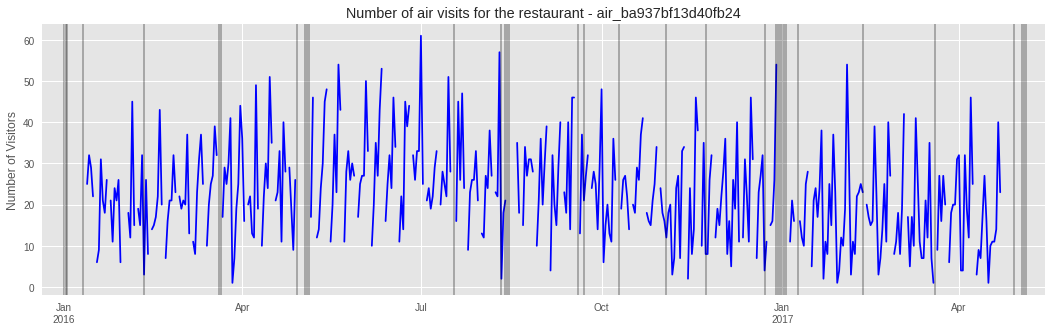

In [22]:
ts_df['visitors'].plot(figsize=(18,5),color='b')
plt.title('Number of air visits for the restaurant - air_ba937bf13d40fb24')
plt.ylabel('Number of Visitors')
for ixx in ts_df.query('holiday_flg==1').index:
    _ = plt.axvline(x=ixx, color='k', alpha = 0.3);

** Observation: ** There are gaps in the restaurant time series air visits data. I have also observed in many other restaurants data as well. 
* This could be because the measurement system which records the visits has note been inplace to record the number of visits
* There are also holidays where the restaurants are closed

### *Fix for the gaps: Interpolation for the dates in between the daterange (resampling)*

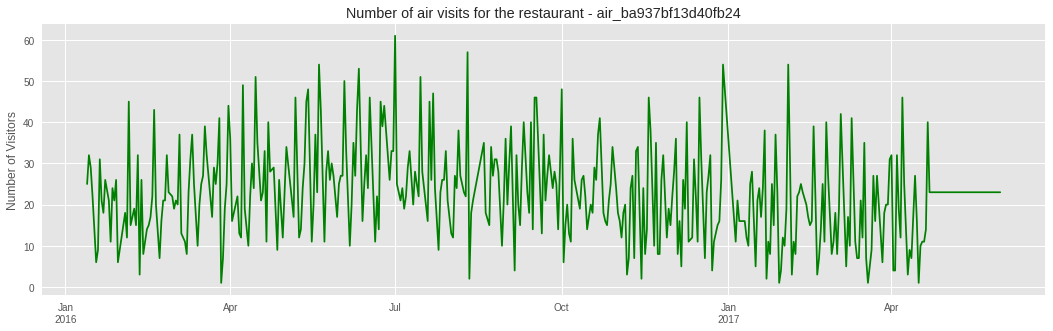

In [23]:
ts_df['visitors'] = ts_df['visitors'].resample('D').mean().interpolate()
ts_df['visitors'].plot(figsize=(18,5),color='g')
plt.title('Number of air visits for the restaurant - air_ba937bf13d40fb24')
plt.ylabel('Number of Visitors')

** Observation:** Due to interpolation there are sharp peaks in the time series

** now lets check the autocorrelation and stationarity of the time series for a restaurant **

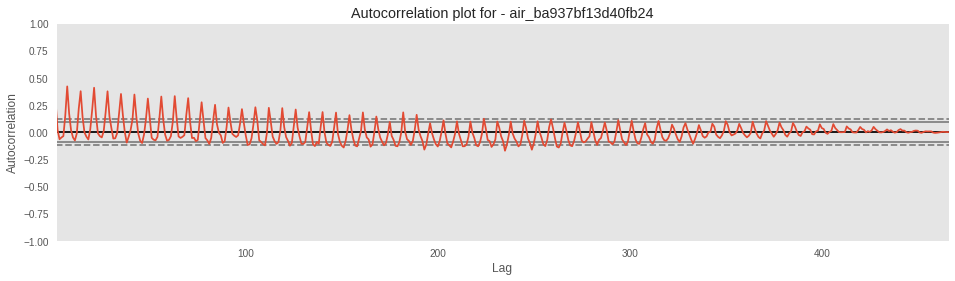

In [24]:
ts.set_index('visit_date',inplace=True)
ts = ts.resample('D').mean().interpolate()
plt.rcParams["figure.figsize"] = (16,4)
autocorrelation_plot(ts)
plt.title('Autocorrelation plot for - air_ba937bf13d40fb24')

### Using Dickey Fuller test for checking the stationarity of a time series

In [25]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean();
    rolstd = timeseries.rolling(window=12,center=False).std();

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.style.use('ggplot')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

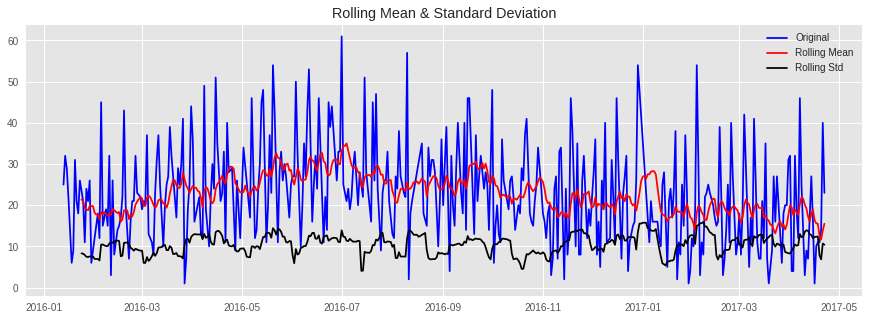

Results of Dickey-Fuller Test:
Test Statistic                  -2.642088
p-value                          0.084607
#Lags Used                      13.000000
Number of Observations Used    452.000000
Critical Value (1%)             -3.444900
Critical Value (5%)             -2.867956
Critical Value (10%)            -2.570187
dtype: float64


In [26]:
test_stationarity(ts.visitors)

**Observation: **The time series is not stationary because the test statistic is not smaller than Critical value(1%). **So some transformations or differencing has to be carried out to make the time series stationary**

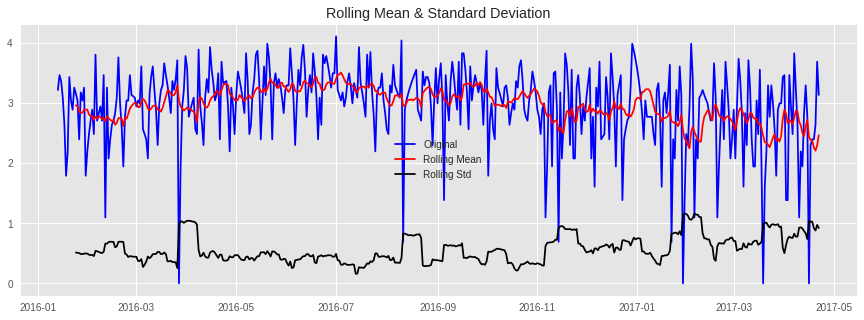

Results of Dickey-Fuller Test:
Test Statistic                  -2.390895
p-value                          0.144323
#Lags Used                      13.000000
Number of Observations Used    452.000000
Critical Value (1%)             -3.444900
Critical Value (5%)             -2.867956
Critical Value (10%)            -2.570187
dtype: float64


In [27]:
ts['visit_log']= ts.visitors.apply(lambda x: np.log(x))
test_stationarity(ts.visit_log)

**Observation: ** Log transformation of the time series did not make it stationary. Critical Value < Test Statisitc

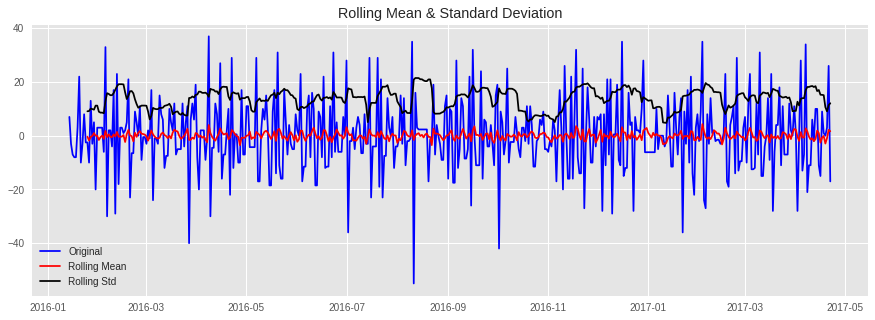

Results of Dickey-Fuller Test:
Test Statistic                -1.209067e+01
p-value                        2.126327e-22
#Lags Used                     1.200000e+01
Number of Observations Used    4.520000e+02
Critical Value (1%)           -3.444900e+00
Critical Value (5%)           -2.867956e+00
Critical Value (10%)          -2.570187e+00
dtype: float64


In [28]:
# Using 1st difference
ts['visit_diff'] = ts.visitors - ts.visitors.shift(1)  
test_stationarity(ts.visit_diff.dropna(inplace=False))

#### **Observation & Conclusion:** 
***Using the 1st differencing helped to make the time series stationary. Critical Value(1%) > Test Statisitic => Reject the Null Hypothesis and thereby by 99% confidence concluding the time series is stationary***

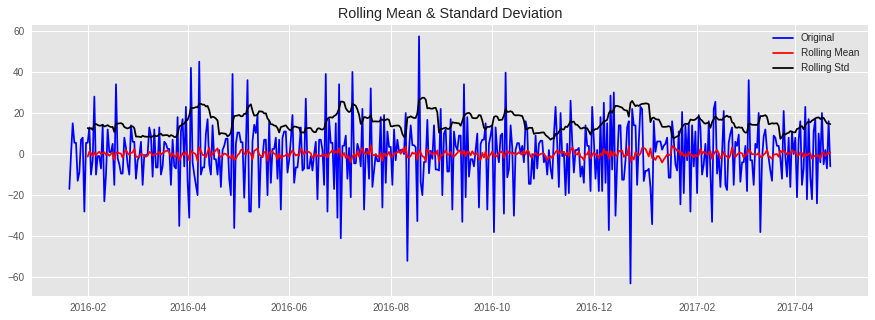

Results of Dickey-Fuller Test:
Test Statistic                -1.006014e+01
p-value                        1.340291e-17
#Lags Used                     1.800000e+01
Number of Observations Used    4.390000e+02
Critical Value (1%)           -3.445334e+00
Critical Value (5%)           -2.868146e+00
Critical Value (10%)          -2.570289e+00
dtype: float64


In [29]:
# seasonal and 1st difference combined additional check
ts['visit_seasonal_diff'] = ts.visit_diff - ts.visit_diff.shift(7)
test_stationarity(ts.visit_seasonal_diff.dropna(inplace=False))

**Observation:** *Still stationary even after the sesonal difference*

**Final Inference: ** ***First difference or seasonal difference works for making the time series stationary*** 

=> **d=1** or if we take the sesaonal difference it could be **D=1**

### ***Inorder to remaining get the parameters for the SARIMAX := (p,d,q)(P,D,Q,m) we need to check the correlation and PACF for the restaurants***

### Visitors ACF and PACF plots for the restaurant air_ba937bf13d40fb24

ACF and PACF of the visitors for air_ba937bf13d40fb24


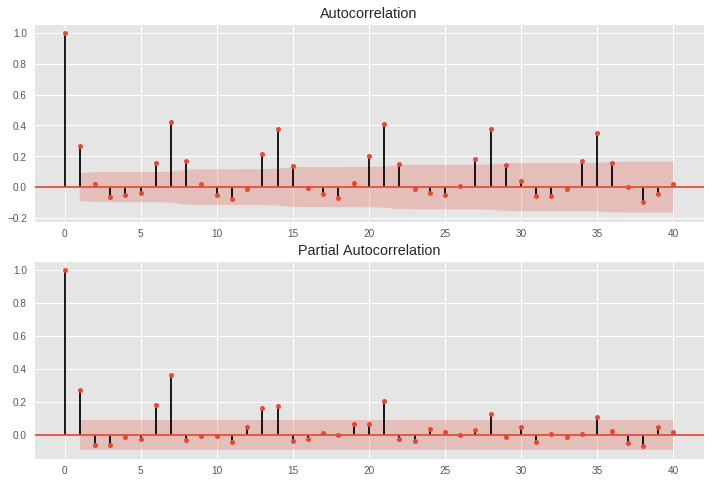

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.visitors, lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.visitors, lags=40, alpha=.05, ax=ax2)
print("ACF and PACF of the visitors for air_ba937bf13d40fb24")

** Observations for air_ba937bf13d40fb24: ** 
* From the ACF plot it can be confirmed that there is seasonal pattern => **m=7**
* Lag 0 and 1 value from the PACF plot is positive

### 1st diff ACF and PACF plots for the restaurant air_ba937bf13d40fb24

ACF and PACF of the visits 1st difference for air_ba937bf13d40fb24


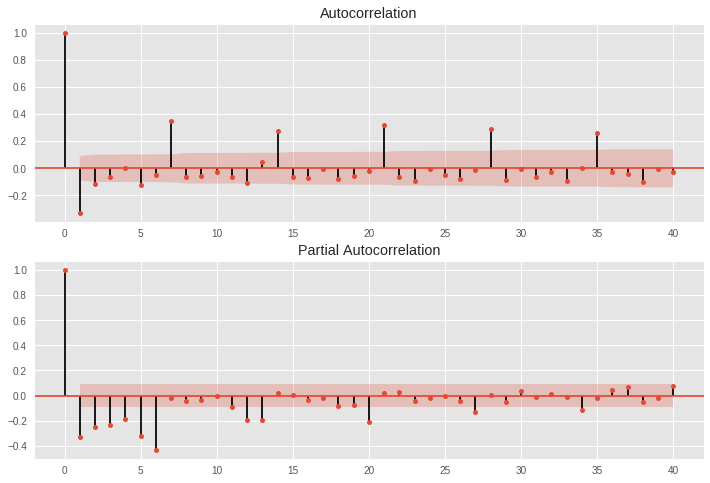

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.visit_diff[1:], lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.visit_diff[1:], lags=40, alpha=.05, ax=ax2)
print("ACF and PACF of the visits 1st difference for air_ba937bf13d40fb24")

** Observations for air_ba937bf13d40fb24: ** 
* Seasonal pattern repeats confirming **m=7**
* lag >7 reaches below 5% could be p=7 should confirm it from the seasonal diff plots

### Seasonal diff ACF and PACF plots for the restaurant air_ba937bf13d40fb24

ACF and PACF of the visits 7day difference for air_ba937bf13d40fb24


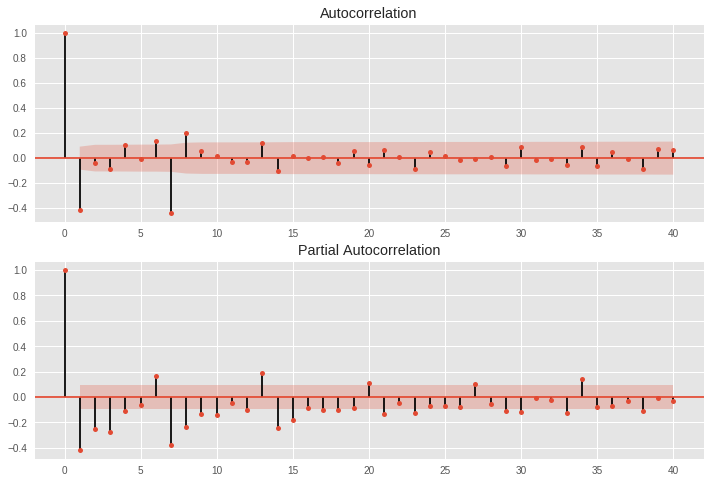

In [40]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.visit_seasonal_diff[8:], lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.visit_seasonal_diff[8:], lags=40, alpha=.05, ax=ax2)
print("ACF and PACF of the visits 7day difference for air_ba937bf13d40fb24")

**Observations :** Using this link as a guide: http://people.duke.edu/~rnau/arimrule.htm 

* From the ACF plot after lag=2 the values are small and enters the 95% confidence interval and at lag=1 the values is negative which means the series slightly overdifferentiated and the number of MA terms will be the lag =2 because the values go to 95% intervals => **q=2**

* From the ACF plot the seasonal difference has a negative lag at lag=7 => **Q=1**

* From the PACF plot at lag=2 the values go beyond 95% confidence intervals => p=2 or could be p=7 but to make it simple i just go with **p=2**

## **Concluding Remarks: **

*From the ACF and PACF plots we found out the parameters for the SARIMAX model:*

### ** SARIMAX Model(p,d,q)(P,D,Q,m) => (2,0,2)(0,1,1,7) i am choosing D=1 instead of d=1 just to use seasonal difference**
### Assumption: * As this is a naive model i will just use the same parameters from the observation made for the restaurant -- air_ba937bf13d40fb24 to all the other restaurants in the dataset*

** I will do some feature engieering now, which is required when i supply exogenous variables**

# 4) Minimal Feature engineering

* In this section i have done some basic feature engineering to get some variants of exogenous variables for the SARIMAX model, but i have not used all of them because the SARIMAX model takes a lot of time to finish evaluation for 829 restaurants.
* my intention of this notebook is to just to have a benchmark for my much complex model (which is in the other notebook)


In [41]:
# Join Store reservation and store info dataframes 

air_data = air_reserve.merge(air_store_info, on='air_store_id', how='left')
hpg_data = hpg_reserve.merge(hpg_store_info, on='hpg_store_id', how='left')

In [42]:
# Add hpg ids to air data and air ids to hpg data

air_data = air_data.merge(store_id_relation, on ='air_store_id', how='left')
hpg_data = hpg_data.merge(store_id_relation, on ='hpg_store_id', how='left')

In [43]:
# Merge data sets 

air_data_full = air_data.merge(hpg_data, on =['air_store_id', 'reserve_datetime', 'visit_datetime'], how='left')
data_full = hpg_data.merge(air_data, on = ['hpg_store_id', 'reserve_datetime', 'visit_datetime'], how='outer')

In [44]:
air_data_full.shape, data_full.shape

((92427, 15), (2088053, 15))

In [45]:
print(air_data_full[(air_data_full.hpg_store_id_x.isnull()==True) & (air_data_full.hpg_store_id_y.isnull()==True)].shape)
print(air_data_full[(air_data_full.hpg_store_id_x.isnull()==True) & (air_data_full.hpg_store_id_y.isnull()==False)].shape)
print(air_data_full[(air_data_full.hpg_store_id_x.isnull()==False) & (air_data_full.hpg_store_id_y.isnull()==True)].shape)
print(air_data_full[(air_data_full.hpg_store_id_x.isnull()==False) & (air_data_full.hpg_store_id_y.isnull()==False)].shape)

(56114, 15)
(0, 15)
(31573, 15)
(4740, 15)


In [46]:
air_data_full[(air_data_full.hpg_store_id_x.isnull()==False) & (air_data_full.hpg_store_id_y.isnull()==False)][air_data_full.hpg_store_id_x!=air_data_full.hpg_store_id_y]

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors_x,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id_x,hpg_store_id_y,reserve_visitors_y,hpg_genre_name,hpg_area_name,latitude_y,longitude_y


In [47]:
# Rename columns
air_data_full = air_data_full.rename(columns= {'reserve_visitors_x' : 'air_reserve_visitors', 'latitude_x': 'latitude',
                                              'longitude_x':'longitude', 'reserve_visitors_y': 'hpg_reserve_visitors',
                                              'hpg_store_id_x':'hpg_store_id'})

# Drop redundant columns
air_data_full = air_data_full.drop(columns={'hpg_store_id_y', 'latitude_y', 'longitude_y'})

In [48]:
print(air_data_full[(air_data_full.air_area_name.isnull()==True) & (air_data_full.hpg_area_name.isnull()==True)].shape)
print(air_data_full[(air_data_full.air_area_name.isnull()==True) & (air_data_full.hpg_area_name.isnull()==False)].shape)
print(air_data_full[(air_data_full.air_area_name.isnull()==False) & (air_data_full.hpg_area_name.isnull()==True)].shape)
print(air_data_full[(air_data_full.air_area_name.isnull()==False) & (air_data_full.hpg_area_name.isnull()==False)].shape)

(0, 12)
(0, 12)
(90284, 12)
(2143, 12)


In [49]:
#Drop hpg_area_name column because no information is added
air_data_full = air_data_full.drop(columns={'hpg_area_name'})

In [50]:
air_data_full.columns

Index(['air_store_id', 'visit_datetime', 'reserve_datetime',
       'air_reserve_visitors', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'hpg_store_id', 'hpg_reserve_visitors', 'hpg_genre_name'],
      dtype='object')

In [51]:
# Datatype conversion row filling
air_data_full['hpg_reserve_visitors'] = air_data_full.apply(
    lambda row: 0 if math.isnan(row['hpg_reserve_visitors'])==True 
    else np.int64(row['hpg_reserve_visitors']),
    axis=1)

In [52]:
air_data_full['hpg_genre_name'] = air_data_full.apply(
    lambda row: ' ' if type(air_data_full.hpg_genre_name)!=str
    else row['hpg_genre_name'],
    axis=1)

In [53]:
sample_submission.loc[:,'air_store_id'] = sample_submission.apply(
    lambda row: str(row['id'])[:-11], axis=1)
sample_submission.loc[:,'visit_date'] = sample_submission.apply(
    lambda row: pd.datetime.strptime(row['id'][-10:], '%Y-%m-%d').date(), axis=1)

In [54]:
print('The length of the forecast in the test set for every restaurant: ',len(sample_submission.visit_date.unique()))

The length of the forecast in the test set for every restaurant:  39


In [55]:
sample_submission.loc[:,'visitors'] = sample_submission.apply(
    lambda row: np.nan, axis=1)

In [56]:
#function to impute missing values from air to hpg
def fill_air_hpg(data, feature, is_string=False):
    """
    Fills missing values from one data set to another.
    :param data: dataframe to impute
    :param feature: feature on the dataframe to impute
    :param is_string: True if feature is string, false if feature is float
    """
    
    feature_x = feature + '_x'
    feature_y = feature + '_y'
    
    #if feature type is string like hpg_store_id, check for NaNs with type
    if is_string == True:
        data[feature_x] = data.apply(
            lambda row: row[feature_y] if type(row[feature_x])!=str else row[feature_x], axis=1)
        data[feature_y] = data.apply(
            lambda row: row[feature_x] if type(row[feature_y])!=str else row[feature_y], axis=1)
    #if feature type is float, check for NaNs using math.isnan()
    else:
        data[feature_x] = data.apply(
            lambda row: row[feature_y] if math.isnan(row[feature_x])==True else row[feature_x], axis=1)
        data[feature_y] = data.apply(
            lambda row: row[feature_x] if math.isnan(row[feature_y])==True else row[feature_y], axis=1)

In [57]:
def fill_general(data, feature):
    """
    Fills missing genre and area name from one data set to another.
    :param data: dataframe to impute
    :param feature: feature on the dataframe to impute
    """
    
    air_feature = 'air_'+feature
    hpg_feature = 'hpg_'+feature
    
    data[air_feature] = data.apply(
        lambda row: row[hpg_feature] if type(row[air_feature])!=str else row[air_feature], axis=1)
    data[hpg_feature] = data.apply(
        lambda row: row[air_feature] if type(row[hpg_feature])!=str else row[hpg_feature], axis=1)

In [58]:
from datetime import datetime
from dateutil.parser import parse

In [59]:
air_data_full.loc[:,'visit_datetime'] = air_data_full.apply(
    lambda row: datetime.strptime(row['visit_datetime'], '%Y-%m-%d %H:%M:%S'), axis=1)
air_data_full.loc[:,'reserve_datetime'] = air_data_full.apply(
    lambda row: datetime.strptime(row['reserve_datetime'], '%Y-%m-%d %H:%M:%S'), axis=1)

In [60]:
air_data_full.loc[:,'visit_date'] = air_data_full.apply(
    lambda row: row['visit_datetime'].date(), axis=1)
air_data_full.loc[:,'reserve_date'] = air_data_full.apply(
    lambda row: row['reserve_datetime'].date(), axis=1)

In [61]:
air_data_visits = air_data_full.loc[:,['air_store_id','hpg_store_id','visit_date','reserve_date',
                                      'air_reserve_visitors','hpg_reserve_visitors']].groupby(
                                        ['air_store_id','visit_date'], as_index=False).agg('sum')

In [63]:
df_air_visit_data = air_visit_data.groupby(['air_store_id','visit_date'], as_index=False).agg('max')
df_air_visit_data['visit_date'] = df_air_visit_data['visit_date'].dt.date

In [64]:
df_air_visit_data = pd.concat([df_air_visit_data, sample_submission])

In [65]:
df_air = air_data_visits.merge(df_air_visit_data, on=['air_store_id','visit_date'], how='outer')

In [66]:
row_delete = set(df_air_visit_data.air_store_id)-set(df_air_visit_data.air_store_id).intersection(
        set(sample_submission.air_store_id))

In [67]:
df_air = df_air.drop(df_air[df_air.air_store_id.isin(row_delete)].index, axis=0).reset_index()

In [68]:
#rename columns on date_info
date_info = date_info.rename(columns={'calendar_date':'visit_date'})

#convert datetime format
date_info['visit_date'] = date_info.apply(
    lambda row: datetime.strptime(row['visit_date'], '%Y-%m-%d').date(), axis=1)

In [69]:
#merge date information
df_air = df_air.merge(date_info, on='visit_date', how='right')

In [70]:
air_features = air_data_full.loc[:,['air_store_id', 'air_genre_name', 'hpg_genre_name',
                                    'air_area_name','latitude','longitude']].groupby(
                                    'air_store_id', as_index=False).agg('max')

In [71]:
df_air = df_air.merge(air_features, on='air_store_id', how='left')
df_air.head()

,index,air_store_id,visit_date,air_reserve_visitors,hpg_reserve_visitors,id,visitors,day_of_week,holiday_flg,air_genre_name,hpg_genre_name,air_area_name,latitude,longitude
0,0,air_00a91d42b08b08d9,2016-10-31,2.0,2.0,NaN,26.0,Monday,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,234,air_03963426c9312048,2016-10-31,12.0,0.0,NaN,17.0,Monday,0,Izakaya,,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018
2,410,air_04cae7c1bc9b2a0b,2016-10-31,13.0,0.0,NaN,27.0,Monday,0,Izakaya,,Hokkaidō Sapporo-shi Kotoni 2 Jō,43.074470,141.300889
3,671,air_0867f7bebad6a649,2016-10-31,2.0,0.0,NaN,12.0,Monday,0,Italian/French,,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018
4,807,air_08cb3c4ee6cd6a22,2016-10-31,20.0,0.0,NaN,32.0,Monday,0,Izakaya,,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,34.756950,134.841177


** Some feature engineering for the genre names**

In [72]:
df_air.loc[:, 'genre_name'] = df_air.apply(
    lambda row: (row['air_genre_name'] + ' ' + row['hpg_genre_name']) 
    if (type(row['air_genre_name']) == str) and (type(row['hpg_genre_name']) == str)
    else row['air_genre_name'], axis=1)

In [73]:
#add feature for restaurants with Japanese in the name
df_air.loc[:,'Japanese_explicit'] = df_air.apply(
    lambda row: 1 if 'Japanese' in str(row.genre_name) else 0, axis=1)

In [74]:
#add feature for restaurants with Japanese food
df_air.loc[:,'Japanese'] = df_air.apply(
    lambda row: 1 if ('Japanese' in str(row.genre_name) or 'Izakaya' in str(row.genre_name)
                      or 'Sukiyaki' in str(row.genre_name) or 'Teppanyaki' in str(row.genre_name)
                      or 'Sushi' in str(row.genre_name)) 
                else 0, axis=1)

In [75]:
#add feature for Italian restaurants
df_air.loc[:,'Italian'] = df_air.apply(
    lambda row: 1 if ('Italian' in str(row.genre_name) or 'Pizza' in str(row.genre_name)) else 0, axis=1)

In [76]:
#add feature for French restaurants
df_air.loc[:,'French'] = df_air.apply(
    lambda row: 1 if 'French' in str(row.genre_name) else 0, axis=1)

In [77]:
#add feature for Korean restaurants
df_air.loc[:,'Korean'] = df_air.apply(
    lambda row: 1 if 'Korean' in str(row.genre_name) else 0, axis=1)

In [78]:
#add feature for restaurants with Chinese food
df_air.loc[:,'Chinese'] = df_air.apply(
    lambda row: 1 if ('Chinese' in str(row.genre_name) or 'Cantonese' in str(row.genre_name)
                      or 'Shanghai' in str(row.genre_name) or 'Sichuan' in str(row.genre_name)
                      or 'Dim Sum' in str(row.genre_name) or 'Taiwanese' in str(row.genre_name)) 
                else 0, axis=1)

In [79]:
#add feature for restaurants with Western food
df_air.loc[:,'Western'] = df_air.apply(
    lambda row: 1 if ('Western' in str(row.genre_name) or 'Italian' in str(row.genre_name)
                      or 'French' in str(row.genre_name) or 'Spanish' in str(row.genre_name)
                      or 'Spain' in str(row.genre_name) or 'Taiwanese' in str(row.genre_name)) 
                else 0, axis=1)

In [80]:
#add feature for restaurants with Chinese food
df_air.loc[:,'Asian'] = df_air.apply(
    lambda row: 1 if (row.Japanese == 1 or row.Korean == 1 or row.Chinese == 1) 
                else 0, axis=1)

In [81]:
df_air.genre_name.unique()

array(['Italian/French  ', 'Izakaya  ', 'Western food  ', 'Dining bar  ',
       'Yakiniku/Korean food  ', 'Bar/Cocktail  ', 'Japanese food  ',
       'Cafe/Sweets  ', 'Creative cuisine  ',
       'Okonomiyaki/Monja/Teppanyaki  ', nan, 'Asian  ', 'Other  ',
       'Karaoke/Party  ', 'International cuisine  '], dtype=object)

In [82]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283122 entries, 0 to 283121
Data columns (total 23 columns):
index                   283122 non-null int64
air_store_id            283122 non-null object
visit_date              283122 non-null object
air_reserve_visitors    29830 non-null float64
hpg_reserve_visitors    29830 non-null float64
id                      32019 non-null object
visitors                250468 non-null float64
day_of_week             283122 non-null object
holiday_flg             283122 non-null int64
air_genre_name          110214 non-null object
hpg_genre_name          110214 non-null object
air_area_name           110214 non-null object
latitude                110214 non-null float64
longitude               110214 non-null float64
genre_name              110214 non-null object
Japanese_explicit       283122 non-null int64
Japanese                283122 non-null int64
Italian                 283122 non-null int64
French                  283122 non-null int64


In [83]:
df_air = df_air.sort_values(['air_store_id', 'visit_date'])

In [84]:
df_air = pd.concat([df_air.drop('day_of_week', axis=1),(pd.get_dummies(df_air.day_of_week))], axis=1)

In [85]:
df_air.drop('index',axis=1,inplace=True)

In [87]:
df_air.head()

,air_store_id,visit_date,air_reserve_visitors,hpg_reserve_visitors,id,visitors,holiday_flg,air_genre_name,hpg_genre_name,air_area_name,...,Chinese,Western,Asian,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
175685,air_00a91d42b08b08d9,2016-07-01,NaN,NaN,NaN,35.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,...,0,1,0,1,0,0,0,0,0,0
176436,air_00a91d42b08b08d9,2016-07-02,NaN,NaN,NaN,9.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,...,0,1,0,0,0,1,0,0,0,0
177147,air_00a91d42b08b08d9,2016-07-04,NaN,NaN,NaN,20.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,...,0,1,0,0,1,0,0,0,0,0
177769,air_00a91d42b08b08d9,2016-07-05,NaN,NaN,NaN,25.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,...,0,1,0,0,0,0,0,0,1,0
178473,air_00a91d42b08b08d9,2016-07-06,NaN,NaN,NaN,29.0,0,Italian/French,,Tōkyō-to Chiyoda-ku Kudanminami,...,0,1,0,0,0,0,0,0,0,1


In [88]:
df_air.drop('id',axis=1,inplace=True)

In [89]:
df_air = df_air.sort_values(['air_store_id', 'visit_date'])
df_air.index = df_air.visit_date

In [90]:
df_air_first = df_air[df_air.air_store_id == 'air_ba937bf13d40fb24']

### *Let us run a SARIMAX model with parameters (2,0,2)(0,1,1,7)*

** Just performing basic checks by using just one restaurant**

In [91]:
arima = sm.tsa.statespace.SARIMAX(df_air_first.visitors,
                                  trend=None,
                                  order=(2,0,2),
                                  seasonal_order=(0,1,1,7),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False).fit(method='powell') 
#later will be increasing the number of iterations

Optimization terminated successfully.
         Current function value: 3.394267
         Iterations: 6
         Function evaluations: 423


**Observation:** The out of the box SARIMAX model is not converging -> Number of iterations have to be increased

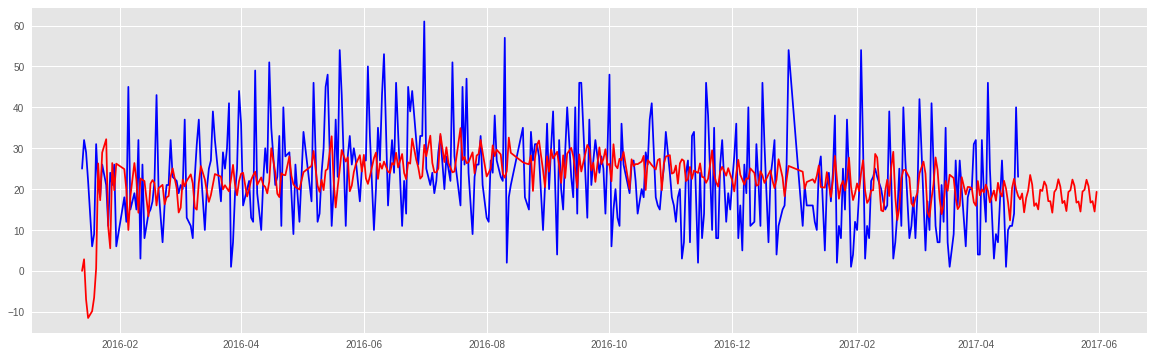

In [135]:
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_air_first.index, df_air_first.visitors, label='Visitors',color="b")
plt.plot(df_air_first.index, arima.predict(), color='red', label='ARIMA')

** Observations:** The predicitions in the red does not look good, May be using exogenous variables could help

** For the exogneous variables i am just using the holiday flag and days of the week because these variables give us some insight if there are more visitors or not -> From the EDA notebook it can be understood that holidays and weekends attract lot more visitors than the normal days. Therefore i choose these as my exogenous variables**

In [93]:
exogenous = df_air_first.loc[:,['holiday_flg','Monday','Tuesday','Wednesday','Thursday','Friday',
                                'Saturday']].astype(float)
endogenous = df_air_first.loc[:,'visitors'].astype(float)

In [113]:
sarimax_model = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                  exog = exogenous,
                                  trend=None,
                                  order=(2,0,2),
                                  seasonal_order=(0,1,1,7),
                                  enforce_stationarity=True,
                                  enforce_invertibility=False).fit(maxiter=500)

In [114]:
start_date = datetime(2017,4,22)
end_date = datetime(2017,5,31)

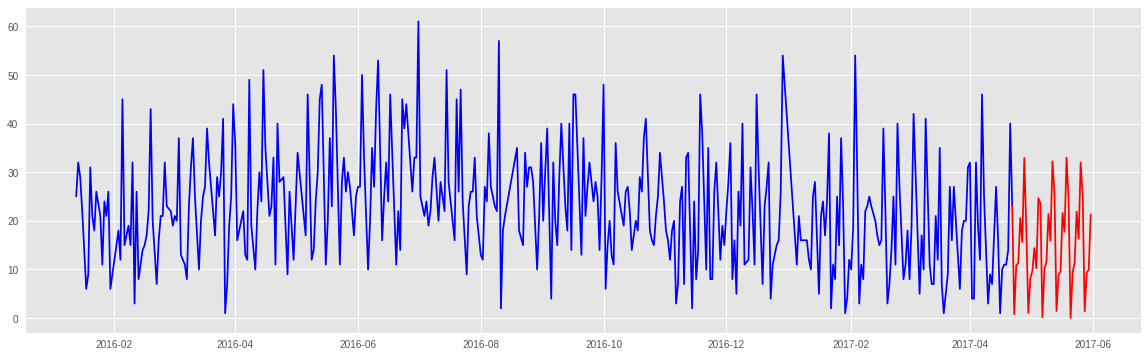

In [115]:
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_air_first.index, df_air_first.visitors, label='Visitors',color="b")
plt.plot(df_air_first.loc[start_date.date():end_date.date(),:].index, sarimax_model.predict(start_date,end_date), color='red', label='SARIMAX')

** Observations: ** Looks a lot better than SARIMAX without exogenous variables

In [97]:
#function to plot acf and pacf plots
def acf_pacf_plots(data, lags=None):
    plt.subplots(1, 3, figsize=(20,6))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [116]:
#function to fit sarimax model for a store
def get_sarimax(data, store):
    
    df = data[data.air_store_id==store]
    print(df.shape[0])
    exogenous = df.loc[:,['holiday_flg','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']].astype(float)
    endogenous = df.loc[:,'visitors'].astype(float)
    
    try:
        if df.shape[0] > 60:
            sarimax_model = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                          exog = exogenous,
                                          trend=None,
                                          order=(2,0,2),
                                          seasonal_order=(0,1,1,7),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False).fit(maxiter=500)

        else: #found an exception for few restaurants which have lesser data
            sarimax_model = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                          exog = exogenous,
                                          trend=None,
                                          order=(1,1,2),
                                          seasonal_order=(0,0,1,7),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False).fit(maxiter=500)
    except ValueError:
        sarimax_model = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                      exog = exogenous,
                                      trend=None,
                                      order=(2,0,1),
                                      seasonal_order=(1,0,0,7),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit(maxiter=500)
    
    start_date = df.shape[0] - 40
    end_date = df.shape[0] -1
    
    df.iloc[-39:,4] = sarimax_model.predict(start_date,end_date).astype(int)
#     print('AIC score: {}'.format(sarimax_model.aic))
    
    return df

In [117]:
df_test = get_sarimax(df_air,'air_ba937bf13d40fb24')

430


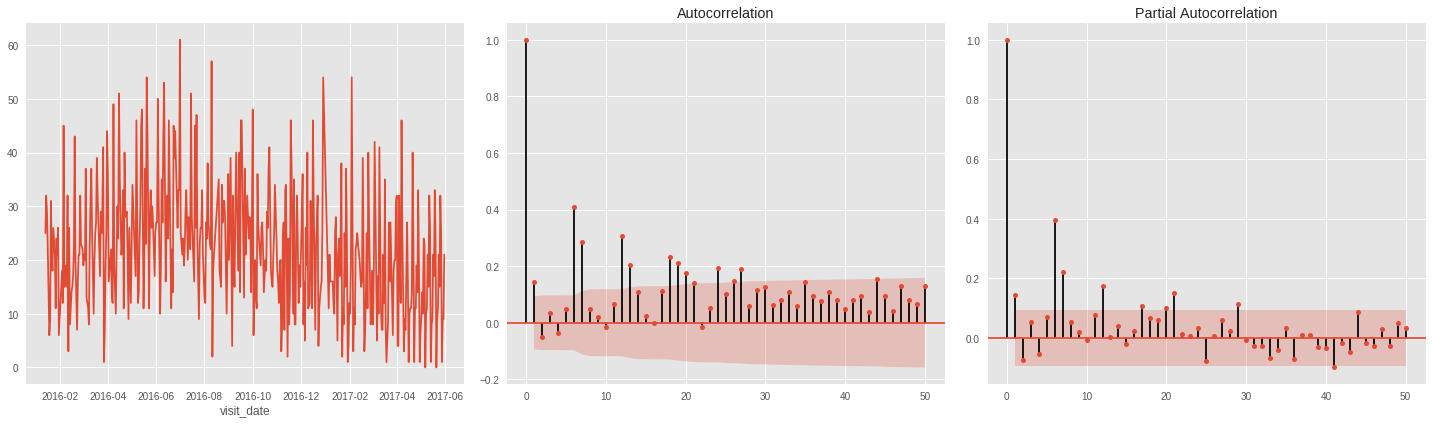

In [118]:
acf_pacf_plots(df_test.visitors, 50)

In [119]:
get_sarimax(df_air,'air_ba937bf13d40fb24').iloc[-39:,:]

430


,air_store_id,visit_date,air_reserve_visitors,hpg_reserve_visitors,visitors,holiday_flg,air_genre_name,hpg_genre_name,air_area_name,latitude,...,Chinese,Western,Asian,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
visit_date,,,,,,,,,,,,,,,,,,,,,
2017-04-23,air_ba937bf13d40fb24,2017-04-23,NaN,NaN,1.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2017-04-24,air_ba937bf13d40fb24,2017-04-24,NaN,NaN,11.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
2017-04-25,air_ba937bf13d40fb24,2017-04-25,NaN,NaN,11.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
2017-04-26,air_ba937bf13d40fb24,2017-04-26,NaN,NaN,19.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2017-04-27,air_ba937bf13d40fb24,2017-04-27,NaN,NaN,14.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2017-04-28,air_ba937bf13d40fb24,2017-04-28,NaN,NaN,33.0,0,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
2017-04-29,air_ba937bf13d40fb24,2017-04-29,NaN,NaN,19.0,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2017-04-30,air_ba937bf13d40fb24,2017-04-30,NaN,NaN,1.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2017-05-01,air_ba937bf13d40fb24,2017-05-01,NaN,NaN,7.0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0


In [123]:
#function to make prediction for each restaurant and concat to prediction dataframe
def create_predictions(data):
    
    df = data[data.air_store_id == 'air_00a91d42b08b08d9']
    df = get_sarimax(df, 'air_00a91d42b08b08d9').iloc[-39:,:]
    
    for store in data.air_store_id.unique()[1:]:
        df_add = data[data.air_store_id==store]
        print('Restaurant {} is done'.format(store))
        df = pd.concat([df, get_sarimax(df_add, store).iloc[-39:,:]])
        
    return df

In [124]:
import time
start=time.time()

In [125]:
df_predictions = create_predictions(df_air)

271
Restaurant air_0164b9927d20bcc3 is done
188
Restaurant air_0241aa3964b7f861 is done
435
Restaurant air_0328696196e46f18 is done
155
Restaurant air_034a3d5b40d5b1b1 is done
290
Restaurant air_036d4f1ee7285390 is done
320
Restaurant air_0382c794b73b51ad is done
337
Restaurant air_03963426c9312048 is done
468
Restaurant air_04341b588bde96cd is done
511
Restaurant air_049f6d5b402a31b2 is done
297
Restaurant air_04cae7c1bc9b2a0b is done
330
Restaurant air_0585011fa179bcce is done
312
Restaurant air_05c325d315cc17f5 is done
507
Restaurant air_0647f17b4dc041c8 is done
326
Restaurant air_064e203265ee5753 is done
261
Restaurant air_066f0221b8a4d533 is done
316
Restaurant air_06f95ac5c33aca10 is done
440
Restaurant air_0728814bd98f7367 is done
470
Restaurant air_0768ab3910f7967f is done
368
Restaurant air_07b314d83059c4d2 is done
333


/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_07bb665f9cdfbdfb is done
419
Restaurant air_082908692355165e is done
467
Restaurant air_083ddc520ea47e1e is done
244
Restaurant air_0845d8395f30c6bb is done
320
Restaurant air_084d98859256acf0 is done
279
Restaurant air_0867f7bebad6a649 is done
259
Restaurant air_08ba8cd01b3ba010 is done
498
Restaurant air_08cb3c4ee6cd6a22 is done
328
Restaurant air_08ef81d5b7a0d13f is done
279
Restaurant air_08f994758a1e76d4 is done
328
Restaurant air_09040f6df960ddb8 is done
266
Restaurant air_0919d54f0c9a24b8 is done
273
Restaurant air_09661c0f3259cc04 is done
325
Restaurant air_09a845d5b5944b01 is done
446
Restaurant air_09fd1f5c58583141 is done
272
Restaurant air_0a74a5408a0b8642 is done
302
Restaurant air_0b184ec04c741a6a is done
421
Restaurant air_0b1e72d2d4422b20 is done
298
Restaurant air_0b9038300f8b2b50 is done
331
Restaurant air_0e1eae99b8723bc1 is done
406
Restaurant air_0e7c11b9abc50163 is done
258
Restaurant air_0f0cdeee6c9bf3d7 is done
307
Restaurant air_0f2f96335f274801 

/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_1dd8f6f47480d1a2 is done
306
Restaurant air_1dea9815ccd36620 is done
285
Restaurant air_1e23210b584540e7 is done
490
Restaurant air_1e665503b8474c55 is done
507
Restaurant air_1eeff462acb24fb7 is done
297
Restaurant air_1f1390a8be2272b3 is done
464
Restaurant air_1f34e9beded2231a is done
192
Restaurant air_1f7f8fa557bc0d55 is done
463
Restaurant air_2009041dbf9264de is done
448
Restaurant air_20619d21192aa571 is done
465
Restaurant air_20add8092c9bb51d is done
331
Restaurant air_2195cd5025a98033 is done
292
Restaurant air_21f5052d5330528d is done
327
Restaurant air_220cba70c890b119 is done
323
Restaurant air_22682e965418936f is done
312
Restaurant air_228f10bec0bda9c8 is done
278
Restaurant air_232dcee6f7c51d37 is done
514
Restaurant air_234d3dbf7f3d5a50 is done
480
Restaurant air_23e1b11aee2a1407 is done
323
Restaurant air_23ee674e91469086 is done
501
Restaurant air_24b9b2a020826ede is done
435
Restaurant air_24e8414b9b07decb is done
273
Restaurant air_2545dd3a00f265e2 

/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_287d2de7d3c93406 is done
509
Restaurant air_28a9fa1ec0839375 is done
402
Restaurant air_28dbe91c4c9656be is done
122
Restaurant air_290e7a57b390f78e is done
386
Restaurant air_298513175efdf261 is done
481
Restaurant air_2a184c1745274b2b is done
320
Restaurant air_2a24aec099333f39 is done
261
Restaurant air_2a3743e37aab04b4 is done
418
Restaurant air_2a485b92210c98b5 is done
165
Restaurant air_2a7f14da7fe0f699 is done
292
Restaurant air_2aab19554f91ff82 is done
429
Restaurant air_2ac361b97630e2df is done
328
Restaurant air_2b8b29ddfd35018e is done
510
Restaurant air_2b9bc9f5f5168ea1 is done
310
Restaurant air_2bffb19a24d11729 is done
318
Restaurant air_2c505f9ad67d4635 is done
319
Restaurant air_2c6c79d597e48096 is done
277
Restaurant air_2c6fef1ce0e13a5a is done
329
Restaurant air_2c989829acbd1c6b is done
417
Restaurant air_2cee51fa6fdf6c0d is done
446
Restaurant air_2d3afcb91762fe01 is done
446
Restaurant air_2d78d9a1f4dd02ca is done
289
Restaurant air_2e7cb1f1a2a9cd6a 

/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_346ade7d29230634 is done
443
Restaurant air_347be2c4feeb408b is done
284
Restaurant air_349278fa964bb12f is done
332
Restaurant air_3525f11ef0bf0c35 is done
440
Restaurant air_35512c42db0868da is done
457
Restaurant air_3561fd1c0bce6a95 is done
439
Restaurant air_35c4732dcbfe31be is done
486
Restaurant air_36429b5ca4407b3e is done
299
Restaurant air_36bcf77d3382d36e is done
515
Restaurant air_37189c92b6c761ec is done
421
Restaurant air_375a5241615b5e22 is done
300
Restaurant air_382f5ace4e2247b8 is done
249
Restaurant air_383f5b2f8d345a49 is done
508
Restaurant air_38746ffe9aa20c7e is done
305
Restaurant air_396166d47733d5c9 is done
308
Restaurant air_396942e6423a2145 is done
300
Restaurant air_397d3f32a7196aa2 is done
285
Restaurant air_3980af67be35afdb is done
279
Restaurant air_3982a2c4ea2ed431 is done
454
Restaurant air_399904bdb7685ca0 is done
496
Restaurant air_39dccf7df20b1c6a is done
510
Restaurant air_3a8a3f8fb5cd7f88 is done
381
Restaurant air_3aa839e8e0cb6c87 

/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_56cd12f31a0afc04 is done
330
Restaurant air_56cebcbd6906e04c is done
318
Restaurant air_56ea46c14b2dd967 is done
320
Restaurant air_57013002b912772b is done
303
Restaurant air_573ecdf81b157d22 is done
411
Restaurant air_57c9eea1a2b66e65 is done
288
Restaurant air_57ed725a1930a5b9 is done
467
Restaurant air_5878b6f2a9da12c1 is done
309
Restaurant air_59cc9b2b209c6331 is done
197
Restaurant air_5a9a6cbeeb434c08 is done
306
Restaurant air_5acc13d655a6e8b2 is done
300
Restaurant air_5afb1cca48ceaa19 is done
288
Restaurant air_5b6d18c470bbfaf9 is done
450
Restaurant air_5b704df317ed1962 is done
257
Restaurant air_5bd22f9cc1426a90 is done
279
Restaurant air_5c65468938c07fa5 is done
478
Restaurant air_5c7489c9ec755e2d is done
236
Restaurant air_5c817ef28f236bdf is done
516
Restaurant air_5cb030b9f0b91537 is done
278
Restaurant air_5cfc537125d97f16 is done
319
Restaurant air_5d7c744c3a2ef624 is done
327
Restaurant air_5d945ade487cdf4d is done
397
Restaurant air_5dea8a7a5bf5eb71 

/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_b28bed4b2e7167b7 is done
330
Restaurant air_b2a639cc7e02edf1 is done
325
Restaurant air_b2d97bd2337c5ba7 is done
330
Restaurant air_b2dcec37b83e2494 is done
297
Restaurant air_b30fffd7ab1e75a5 is done
241
Restaurant air_b3180b74332ba886 is done
423
Restaurant air_b3a824511477a4ed is done
281
Restaurant air_b439391e72899756 is done
321
Restaurant air_b45b8e456f53942a is done
303
Restaurant air_b4f32bcc399da2b9 is done
472
Restaurant air_b5598d12d1b84890 is done
303
Restaurant air_b5bdd318005d9aa4 is done
274
Restaurant air_b60cc7d6aee68194 is done
498
Restaurant air_b711b43ae472cb6b is done
272
Restaurant air_b7fa3d2fca744dd2 is done
432
Restaurant air_b80fed1a07c817d2 is done
249
Restaurant air_b88192b35ac03c24 is done
331


/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_b8925441167c3152 is done
250
Restaurant air_b8a5ee69e5fdcc5b is done
328
Restaurant air_b8d9e1624baaadc2 is done
289
Restaurant air_b9e27558fb8bd5c4 is done
418
Restaurant air_ba495cccc8f0f237 is done
510
Restaurant air_ba937bf13d40fb24 is done
430
Restaurant air_bac5f4441db21db9 is done
287
Restaurant air_baf28ac9f13a307d is done
254
Restaurant air_bb09595bab7d5cfb is done
315
Restaurant air_bb26d6d079594414 is done
364
Restaurant air_bb4ff06cd661ee9b is done
106
Restaurant air_bbe1c1a47e09f161 is done
259
Restaurant air_bc991c51d6613745 is done
306
Restaurant air_bc9a129e11a2efe0 is done
334
Restaurant air_bcce1ea4350b7b72 is done
323
Restaurant air_bd74a9222edfdfe1 is done
331
Restaurant air_bdd32aa407c16335 is done
484
Restaurant air_bebd55ed63ab2422 is done
295
Restaurant air_bed603c423b7d9d4 is done
313
Restaurant air_bedd35489e666605 is done
286
Restaurant air_bf13014b6e3e60ca is done
273
Restaurant air_bf21b8350771879b is done
435
Restaurant air_bf617aa68d5f1cfa 

/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_cb935ff8610ba3d3 is done
230
Restaurant air_cbe139af83feb388 is done
457
Restaurant air_cbe867adcf44e14f is done
281
Restaurant air_cc1a0e985ce63711 is done
331
Restaurant air_cc35590cd1da8554 is done
270
Restaurant air_ccd19a5bc5573ae5 is done
330
Restaurant air_cd4b301d5d3918d8 is done
227
Restaurant air_cd5f54969be9ed08 is done
283
Restaurant air_ced6297e5bdf5130 is done
463
Restaurant air_cf2229e64408d9fe is done
265
Restaurant air_cf5ab75a0afb8af9 is done
215
Restaurant air_cfcc94797d2b5d3d is done
301
Restaurant air_cfdeb326418194ff is done
446
Restaurant air_d00161e19f08290b is done
503
Restaurant air_d00a15343325e5f7 is done
279
Restaurant air_d07e57b21109304a is done
330
Restaurant air_d0a1e69685259c92 is done
489
Restaurant air_d0e8a085d8dc83aa is done
512
Restaurant air_d138b593ebda55cc is done
485
Restaurant air_d1418d6fd6d634f2 is done
313
Restaurant air_d186b2cb0b9ce022 is done
311
Restaurant air_d1f20424f76cc78e is done
292
Restaurant air_d34c0861a2be94cb 

/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_dabfbd0ec951925a is done
281
Restaurant air_dad0b6a36138f309 is done
272
Restaurant air_db1233ad855b34d5 is done
327
Restaurant air_db4b38ebe7a7ceff is done
496
Restaurant air_db80363d35f10926 is done
494
Restaurant air_dbf64f1ce38c7442 is done
313
Restaurant air_dc0e080ba0a5e5af is done
332
Restaurant air_dc71c6cc06cd1aa2 is done
326
Restaurant air_de692863bb2dd758 is done
472
Restaurant air_de803f7e324936b8 is done
333


/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_de88770300008624 is done
506
Restaurant air_dea0655f96947922 is done
511
Restaurant air_df507aec929ce5f6 is done
312
Restaurant air_df554c4527a1cfe6 is done
205
Restaurant air_df5cf5cd03eb68d0 is done
384
Restaurant air_df843e6b22e8d540 is done
321
Restaurant air_df9355c47c5df9d3 is done
261
Restaurant air_dfad598ff642dab7 is done
485
Restaurant air_dfe068a1bf85f395 is done
289
Restaurant air_e00fe7853c0100d6 is done
188
Restaurant air_e0118664da63a2d0 is done
369
Restaurant air_e01d99390355408d is done
471
Restaurant air_e053c561f32acc28 is done
331
Restaurant air_e08b9cf82057a170 is done
330
Restaurant air_e0aee25b56a069f2 is done
277
Restaurant air_e0e69668214ff972 is done
280
Restaurant air_e0f241bd406810c0 is done
442
Restaurant air_e1b76fcb5208fb6b is done
334
Restaurant air_e2208a79e2678432 is done
289
Restaurant air_e270aff84ac7e4c8 is done
509
Restaurant air_e3020992d5fe5dfd is done
278
Restaurant air_e34c631c766f2766 is done
326
Restaurant air_e42bdc3377d1eee7 

/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_e483f5b3c4f310e0 is done
443
Restaurant air_e524c6a9e06cc3a1 is done
234
Restaurant air_e55abd740f93ecc4 is done
452
Restaurant air_e57dd6884595f60d is done
443
Restaurant air_e58f669b6f1a08ce is done
393
Restaurant air_e5cf003abcc5febb is done
440
Restaurant air_e64de0a6bf0739af is done
259
Restaurant air_e657ca554b0c008c is done
293
Restaurant air_e700e390226d9985 is done
460
Restaurant air_e76a668009c5dabc is done
309
Restaurant air_e7d2ac6d53d1b744 is done
394
Restaurant air_e7fbee4e3cfe65c5 is done
296
Restaurant air_e88bbe2ede3467aa is done
485
Restaurant air_e89735e80d614a7e is done
277
Restaurant air_e8ed9335d0c38333 is done
374
Restaurant air_e9ebf7fc520ac76a is done
453
Restaurant air_ea6d0c3acf00b22a is done
294
Restaurant air_ea7c16131980c837 is done
437
Restaurant air_eb120e6d384a17a8 is done
462
Restaurant air_eb20a89bba7dd3d0 is done
410
Restaurant air_eb2d2653586315dd is done
458
Restaurant air_eb5788dba285e725 is done
296
Restaurant air_ebd31e812960f517 

/home/namanda/anaconda3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Restaurant air_fe58c074ec1445ea is done
385
Restaurant air_fea5dc9594450608 is done
313
Restaurant air_fee8dcf4d619598e is done
327
Restaurant air_fef9ccb3ba0da2f7 is done
284
Restaurant air_ffcc2d5087e1b476 is done
282
Restaurant air_fff68b929994bfbd is done
308


In [126]:
end=time.time()
print('the execution Time: ',str(end-start))

the execution Time:  3749.36323261261


In [127]:
df_predictions.shape

(32019, 27)

In [128]:
df_predictions['id'] = df_predictions['air_store_id'] + '_' + df_predictions['visit_date'].astype(str)

In [129]:
df_predictions = df_predictions[['id','visitors']]
df_predictions = df_predictions.reset_index().drop('visit_date', axis=1)

In [130]:
df_predictions[df_predictions.visitors<0]

,id,visitors
704,air_0768ab3910f7967f_2017-04-25,-6.0
1215,air_0919d54f0c9a24b8_2017-04-29,-8.0
2505,air_17a6ab40f97fd4d8_2017-05-02,-1.0
2519,air_17a6ab40f97fd4d8_2017-05-16,-1.0
2533,air_17a6ab40f97fd4d8_2017-05-30,-1.0
4056,air_25e9888d30b386df_2017-04-23,-1.0
4063,air_25e9888d30b386df_2017-04-30,-2.0
4070,air_25e9888d30b386df_2017-05-07,-2.0
4077,air_25e9888d30b386df_2017-05-14,-2.0
4084,air_25e9888d30b386df_2017-05-21,-1.0


In [131]:
df_predictions.loc[:,'visitors'] = df_predictions.apply(
    lambda row: row['visitors'] if row['visitors']>0 else 0, axis=1)

In [132]:
df_predictions.to_csv('submission_arima.csv', index=False)

In [133]:
df_predictions.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,6.0
1,air_00a91d42b08b08d9_2017-04-24,18.0
2,air_00a91d42b08b08d9_2017-04-25,26.0
3,air_00a91d42b08b08d9_2017-04-26,28.0
4,air_00a91d42b08b08d9_2017-04-27,30.0


## RMSLE Score from the competition

Public Leaderboard: 
![Public LB](submissions/arima_baseline.PNG)


Public Leaderboard vs Private Leaderboard 
![Public LB](submissions/publicVprivateLB_arima.PNG)

** Final Remarks:** Clearly the model is overfitting a lot. The underperformance of this model could be because: 

* The SARIMAX model in this notebook is a very naive model and it is used out of the box without any parameter tuning

* The model is not cross validated and feature engineering is very weak

* The dataset also has lot of gaps in the data, by interpolating the data in between the daterange basically adds noise to the data

* The exogenous variables used are also very naive and i think this could be also the reason for Overfitting

** May be better feature engineering and stacking might help in improving the RMSLE score**
